In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# View columns in the measurement table
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# View columns in the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last date in the Measurement table
meas_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = meas_dates[0]
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=364)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query)
prcp_df.set_index('date', inplace=True)
prcp_clean = prcp_df.dropna(how='any')
# prcp_clean.head(20)

# Sort the dataframe by date - MS: already done with order_by in query but repeating
prcp_sorted = prcp_clean.sort_values(by='date',ascending=True)
prcp_sorted.head()

2017-08-23
2016-08-24 00:00:00


,prcp
date,
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.00
2016-08-25,0.21


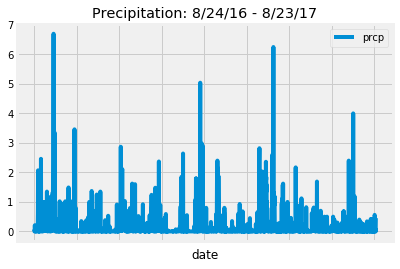

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_sorted.plot()

plt.title("Precipitation: 8/24/16 - 8/23/17")
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_sorted.describe()

,prcp
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset
stations_count = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {stations_count} ")

Stations Available: 9 


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print(f"Most to Least Active Stations:")
station_activity                                 

Most to Least Active Stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
most_active_station = station_activity[0][0]

most_active_temps = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Station {most_active_station} Temperature")
print("---------------------------------")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Station USC00519281 Temperature
---------------------------------
Low: 54.0 High: 85.0 Average: 71.7


In [18]:
# Choose the station with the highest number of temperature observations.
station_tobs_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

most_tobs_station = station_tobs_count[0][0]

# Query the last 12 months of temperature observation data for this station
most_tobs_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == most_tobs_station).all()

# Create a dataframe to hold query data
most_tobs_df = pd.DataFrame(most_tobs_query)
most_tobs_df.head()

,tobs
0,80.0
1,80.0
2,75.0
3,73.0
4,78.0


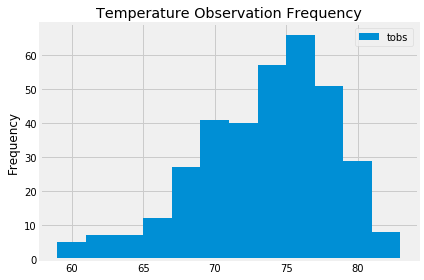

In [19]:
# Plot the results as a histogram using bins=12
most_tobs_df.plot.hist(bins=12, title="Temperature Observation Frequency")
plt.tight_layout()
plt.savefig("Images/tobs_frequency.png")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-05-14','2017-05-21')
print(trip_temps)

[(68.0, 74.5909090909091, 80.0)]


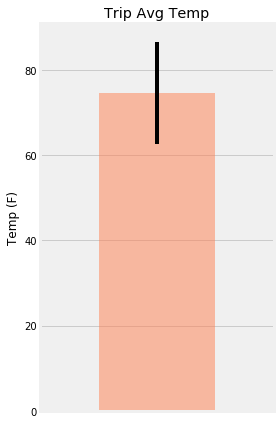

In [22]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temps_df = pd.DataFrame(trip_temps, columns=['tmin', 'tavg', 'tmax'])
trip_temps_df.head()

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df.plot.bar(y='tavg', yerr=(trip_temps_df['tmax'] - trip_temps_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp] # I'm having trouble applying a function to this, e.g. func.sum()
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

precipitation_df = pd.DataFrame(precipitation('2017-05-14','2017-05-21'))
precipitation_df

,station,name,latitude,longitude,elevation,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.00
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.17
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.05
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,NaN


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals('01-01')

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-05-14'
end_date = '2017-05-21'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).all()

# Strip off the year and save a list of %m-%d strings
trip_dates = [date[0] for date in dates]
trip_dates_stripped = [date[5:] for date in trip_dates]

# Find the start month/day and the end month/day
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).\
                 filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                 filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                 group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print(f"Aggregate Daily Normals for {start_month_day} to {end_month_day}")
daily_normals 

Aggregate Daily Normals for 05-14 to 05-21


[(63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals, columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date'] = trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date', inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-05-14,63.0,73.892857,80.0
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0
2017-05-19,65.0,73.807018,79.0
2017-05-20,68.0,73.896552,79.0
2017-05-21,64.0,72.964286,80.0


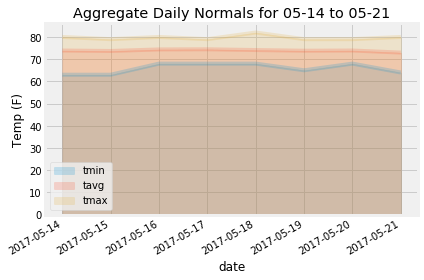

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.title(f"Aggregate Daily Normals for {start_month_day} to {end_month_day}")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()